In [98]:
# import necessary modules
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import pandas as pd
from mpl_toolkits.basemap import Basemap
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd


#get the file path for loading, data file is under the same dir with the notebook
filename="20121015_00_ecmwf_ensemble_forecast.PRESSURE_LEVELS.EUR_LL10.120.pl.nc"
filepath=os.path.join(os.getcwd(),filename)

# read the raw data and extract the needed data
# exrtact the value of Geopotential under the pressure of 500 hPA in the certain
Pressure_Levels_data = nc.Dataset(filepath,"r")
g=9.80655
# get all the dimension value
nd_1,nd_2,nd_3,nd_4,nd_5 = Pressure_Levels_data.variables['Geopotential_isobaric'][:].shape
# get the necessary raw data
Geopotential_Isobaric_500 = Pressure_Levels_data.variables['Geopotential_isobaric'][0,:,7,:,:]/g
# reshape the dataset into form of (51,41*101)
Geopotential_Isobaric_500_reshaped = np.reshape(Geopotential_Isobaric_500,(nd_2, nd_4 * nd_5))
# prepare the longitude and latitude value for contour
longitude = Pressure_Levels_data['lon'][:]
latitude = Pressure_Levels_data['lat'][:]
(lon, lat) = np.meshgrid(longitude, latitude)

# use PCA to reduce dimensions under the condition of reaching 80% of all the member infomation
exp_var = 0
n_pc = 0
while exp_var < 0.8:
    n_pc = n_pc + 1
    pca = PCA(n_components = n_pc)
    pca.fit(Geopotential_Isobaric_500_reshaped)
    exp_var = sum(pca.explained_variance_ratio_)

# get the transformed raw data in the dimension-reduced space    
pca_transformed_data = pca.transform(Geopotential_Isobaric_500_reshaped)

pca_components = np.reshape(pca.components_, (9,nd_4,nd_5)) 

df = pd.DataFrame({'PC1':pca_transformed_data[:, 0],
                   'PC2':pca_transformed_data[:, 1]})

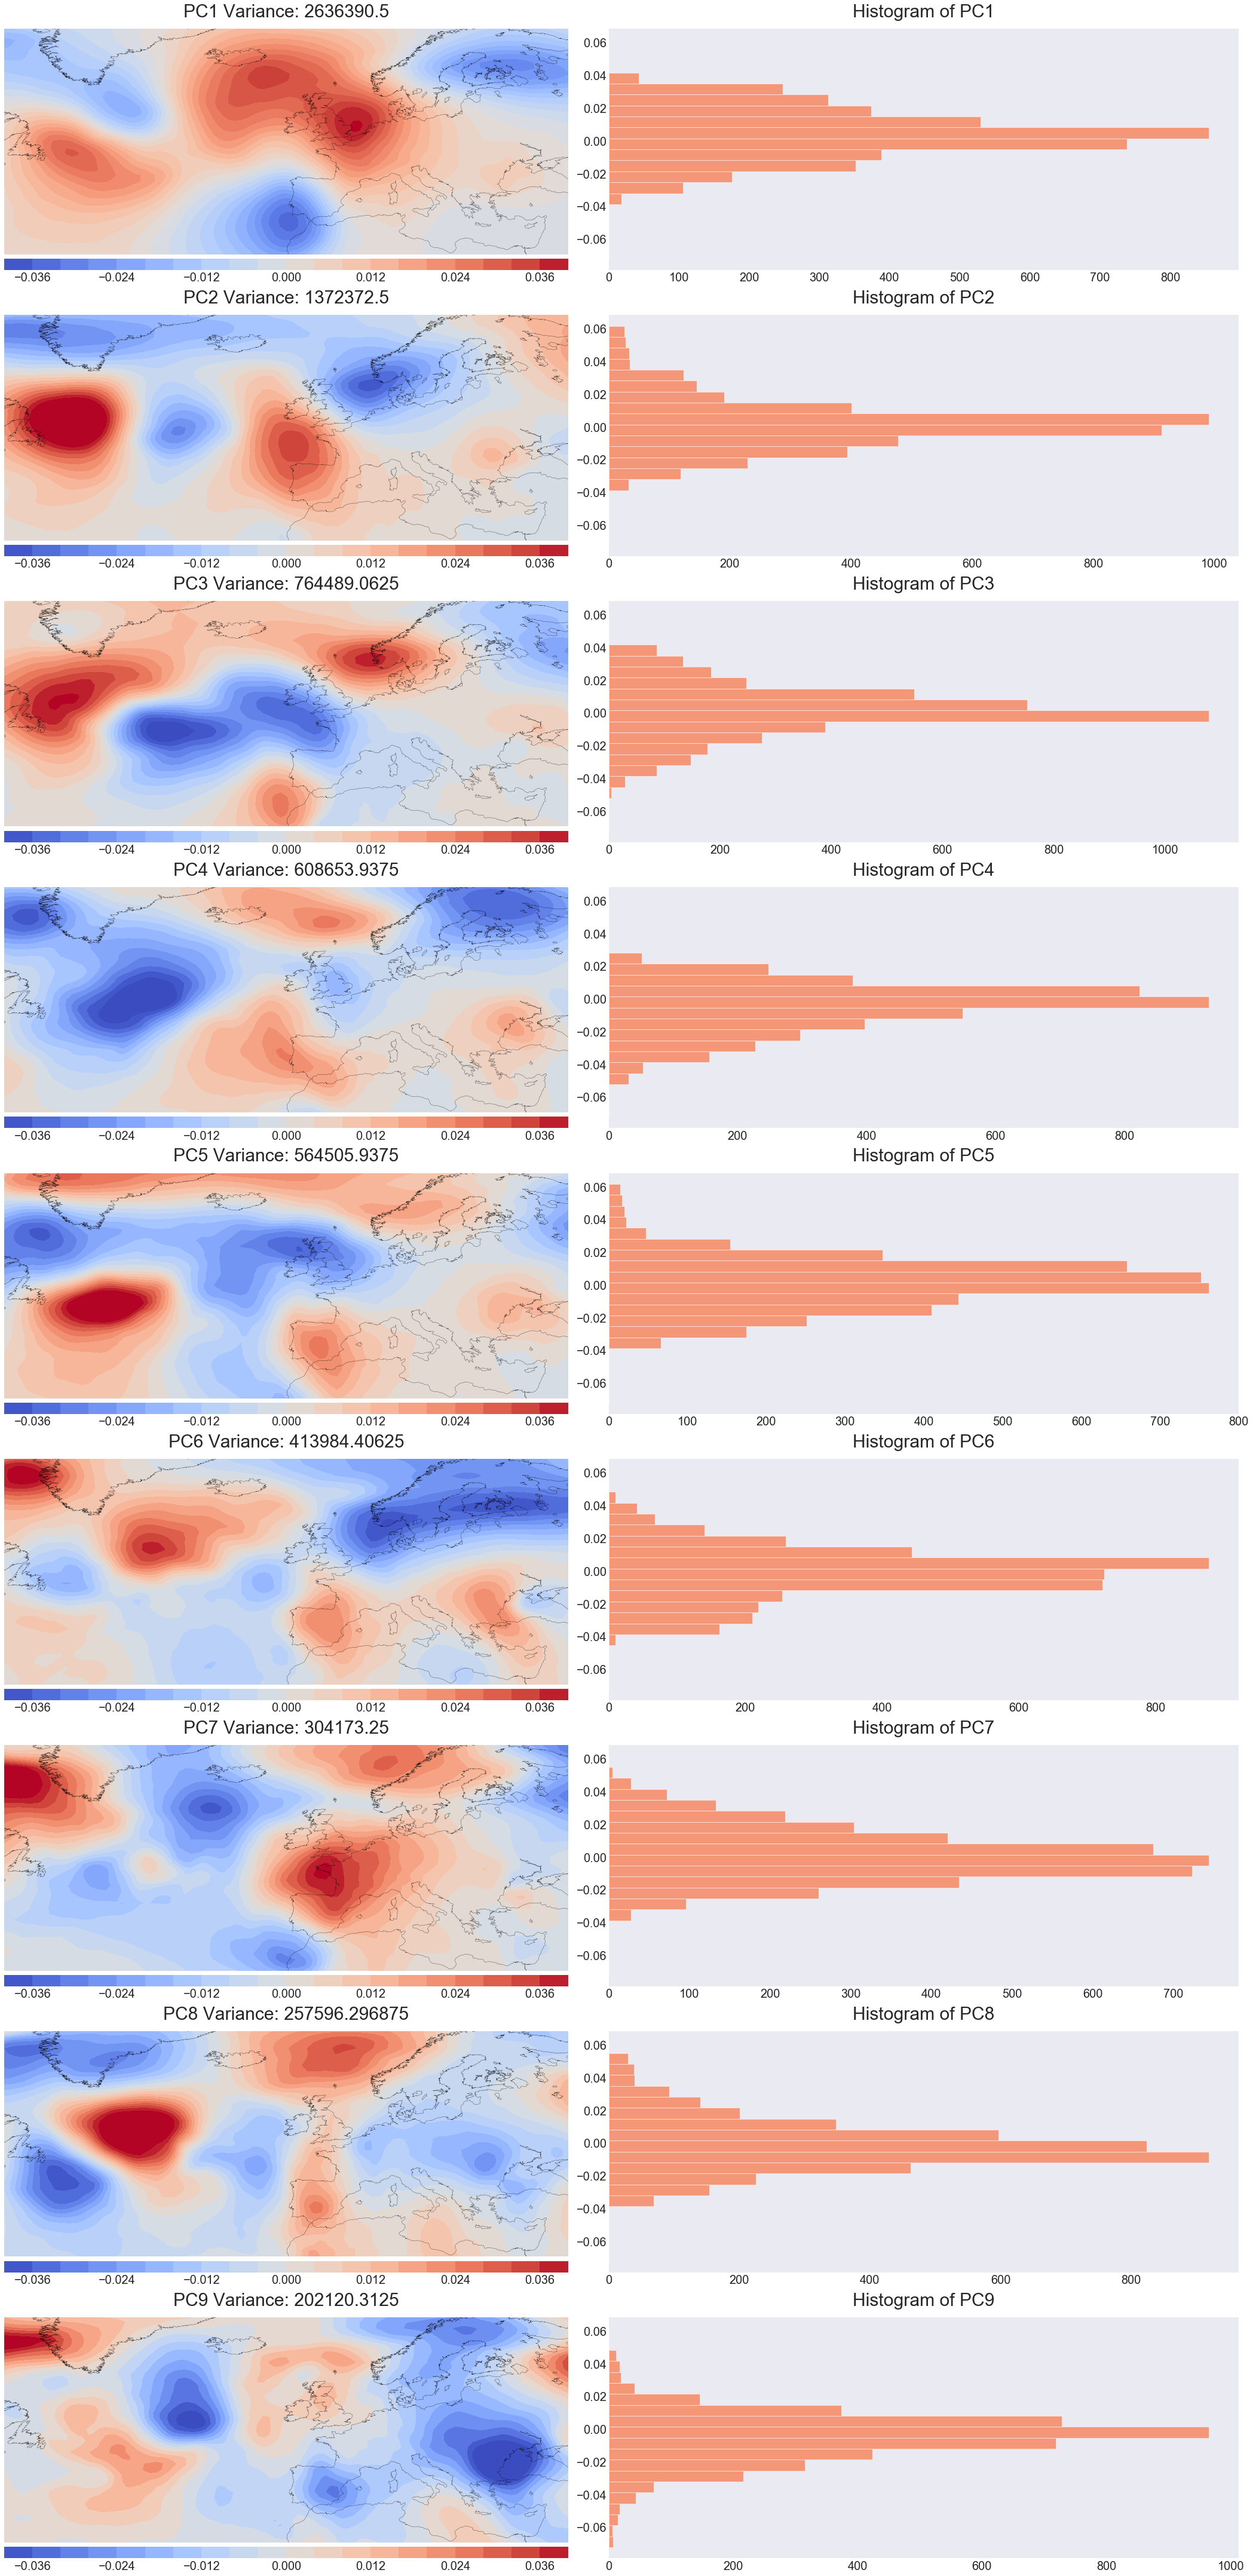

In [56]:
#plot the 9 contour which contains the most information of all 51 members
pp = PdfPages('Ensemble Member Comparison.pdf')
fig = plt.figure(figsize=(30,60))
plt.style.use('seaborn-dark')
plt.subplots_adjust(hspace = 10,wspace = 2.5)
xMax=np.max([np.max(pca.components_[i]) for i in range(9)]) 
xMin=np.max([np.min(pca.components_[i])*-1 for i in range(9)])*-1
allbins = np.linspace(xMax, xMin, 20)
for i in range(9):
    ax0 = fig.add_subplot(9,2,i*2+1)
    ax0.set_title("PC{0} Variance: {1}".format(i+1,pca.explained_variance_[i]),fontsize=30,pad=20)
    map = Basemap(projection='cyl',llcrnrlat= latitude[-1],urcrnrlat= latitude[0],resolution='l', llcrnrlon=longitude[0],urcrnrlon=longitude[-1],ax=ax0)
    map.drawcoastlines(linewidth=0.3)
    ctf=map.contourf(lon,lat,pca_components[i],cmap='coolwarm',levels=25,vmin=-0.04,vmax=0.04)
    #cb=map.colorbar(ctf,ax=ax0, location='bottom',pad=0.2)
    #cb.ax.tick_params(labelsize=20)
    #cb.set_clim(-0.04,0.04)
    m = plt.cm.ScalarMappable(cmap=matplotlib.cm.coolwarm)
    m.set_array(pca_components[i])
    m.set_clim(-0.04,0.04)
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    cb=plt.colorbar(m, boundaries=np.linspace(-0.04, 0.04, 21),orientation="horizontal",cax=cax)
    cb.ax.tick_params(labelsize=20)
    
    ax1 = fig.add_subplot(9,2,(i+1)*2)
    ax1.set_title("Histogram of PC{0}".format(i+1),fontsize=30,pad=20)
    #sns.distplot(pca.components_[i], kde=False, vertical=True, bins=allbins,hist_kws={"histtype": "bar", "color": "red","edgecolor":"k"})
    ax1.hist(pca.components_[i], orientation="horizontal", range=(xMin,xMax),bins=20,histtype = "bar", color="orangered",edgecolor="white",alpha=0.5)
    ax1.tick_params(axis="x", labelsize=20)
    ax1.tick_params(axis="y", labelsize=20)
    
    plt.tight_layout()
plt.savefig('All_PCs_manuel.pdf',bbox_inches="tight")  
pp.close()

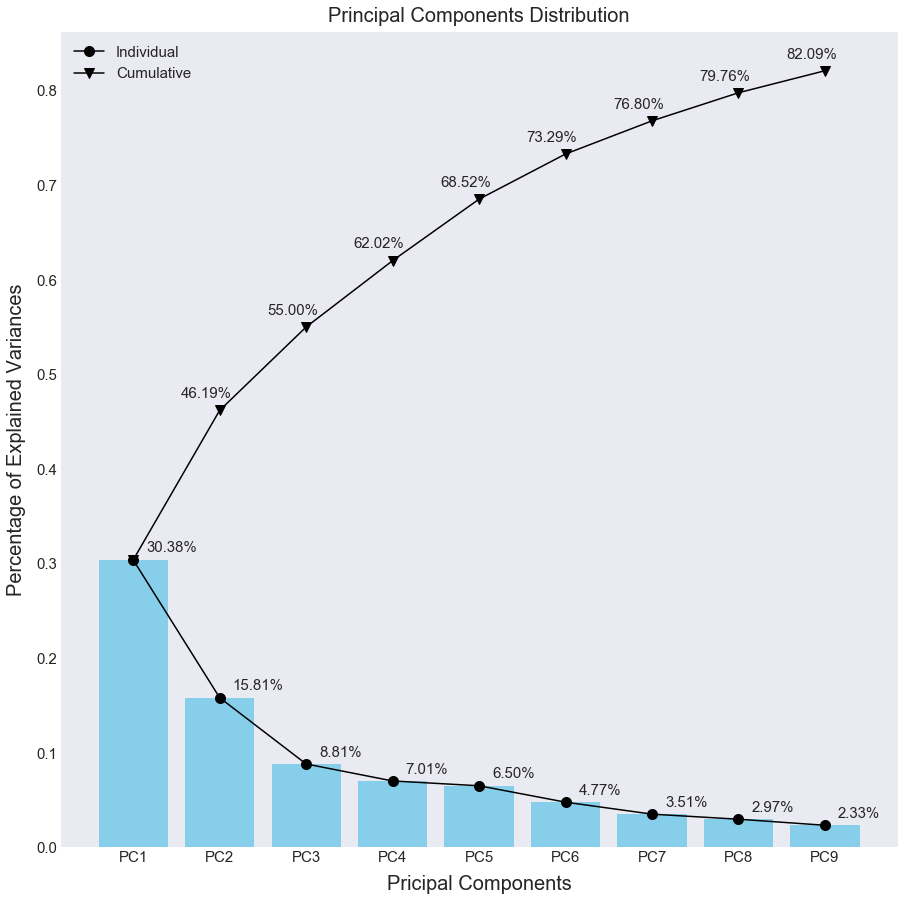

In [7]:
pp = PdfPages('Principal Components Distribution.pdf')
PC_labels = ["PC" + str(i+1) for i in range(9)]
plt.style.use('seaborn-dark')

fig = plt.subplots(figsize = (15, 15))
ax=plt.subplot()

p1=ax.plot(PC_labels,pca.explained_variance_ratio_,color='k',marker='o',markersize=10)
rects=ax.bar(PC_labels,pca.explained_variance_ratio_,color='skyblue').patches
labels=['%.2f%%' % (x * 100) for x in pca.explained_variance_ratio_]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x()+0.55, height+0.005, label,ha='left', va='bottom',size=15)

p2=ax.plot(PC_labels,pca.explained_variance_ratio_.cumsum(),color='k',marker='v',markersize=10)
heightSum=rects[0].get_height()
evrSum=pca.explained_variance_ratio_[0]
for i in range(1,9):
    height = rects[i].get_height()
    heightSum=heightSum+height
    evrSum=evrSum+pca.explained_variance_ratio_[i]
    ax.text(rects[i].get_x()-0.05, heightSum+0.01, '%.2f%%' % (evrSum * 100),ha='left', va='bottom',size=15)

ax.set_xlabel("Pricipal Components",labelpad=10,fontsize=20)
ax.set_ylabel("Percentage of Explained Variances",labelpad=10,fontsize=20)
ax.set_title("Principal Components Distribution", fontsize=20, pad=10)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
l=ax.legend((p1,p2),fontsize=15)
l.get_texts()[0].set_text("Individual")
l.get_texts()[1].set_text("Cumulative")

plt.savefig(pp, format='pdf', bbox_inches="tight")
pp.close()

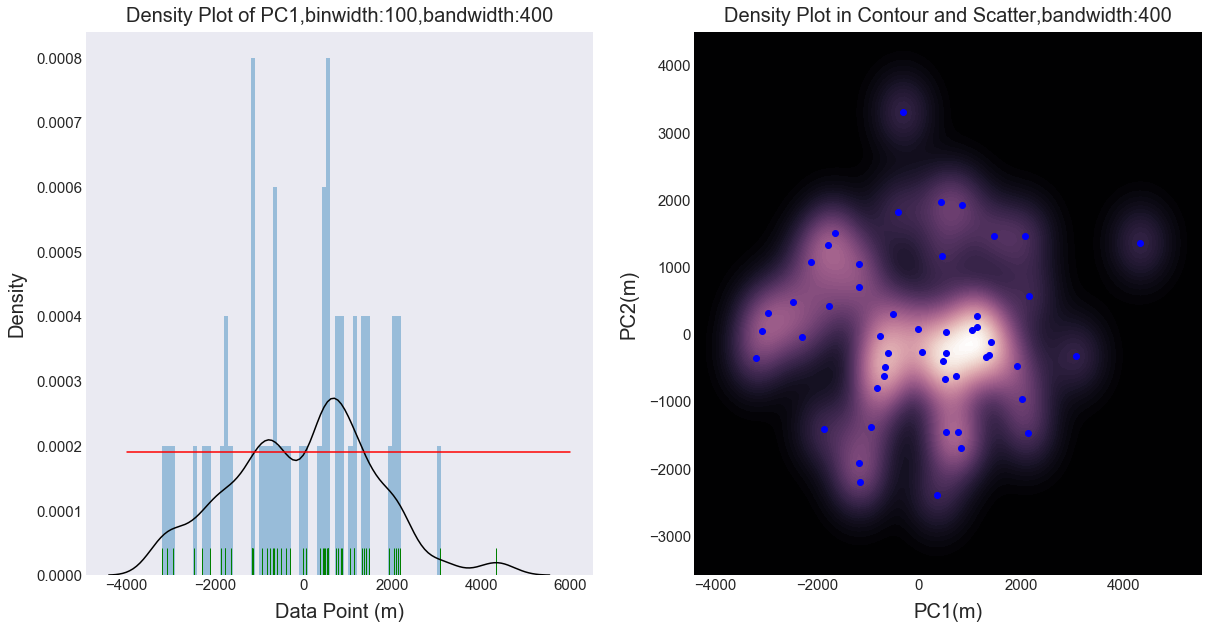

In [120]:
DrawDensityPlotOfFirstTwoPCs(df["PC1"],df["PC2"],100,400,True,0.00019)

In [57]:
np.argwhere(np.diff(np.sign(ax.lines[0].get_ydata() - np.full(ax.lines[0].get_xdata().shape,0.00019)))).flatten()

array([41, 50, 56, 73])

In [78]:
def GetCluster(indexStart,indexEnd):
    arrIndex=[]
    for x in df.PC1:
        if x >= xData[indexStart] and x <= xData[indexEnd+1]:
            arrIndex.append(df[df["PC1"]==x].index[0]) 
    return arrIndex

In [89]:
cluster1=GetCluster(40,50)

cluster2=GetCluster(56,73)

fullIndex=np.arange(51)

In [109]:
labels_=[]
for i in fullIndex:
    if (i in cluster1)==True:
        labels_.append(1)
    elif (i in cluster2)==True:
        labels_.append(2)
    else:
        labels_.append(0)

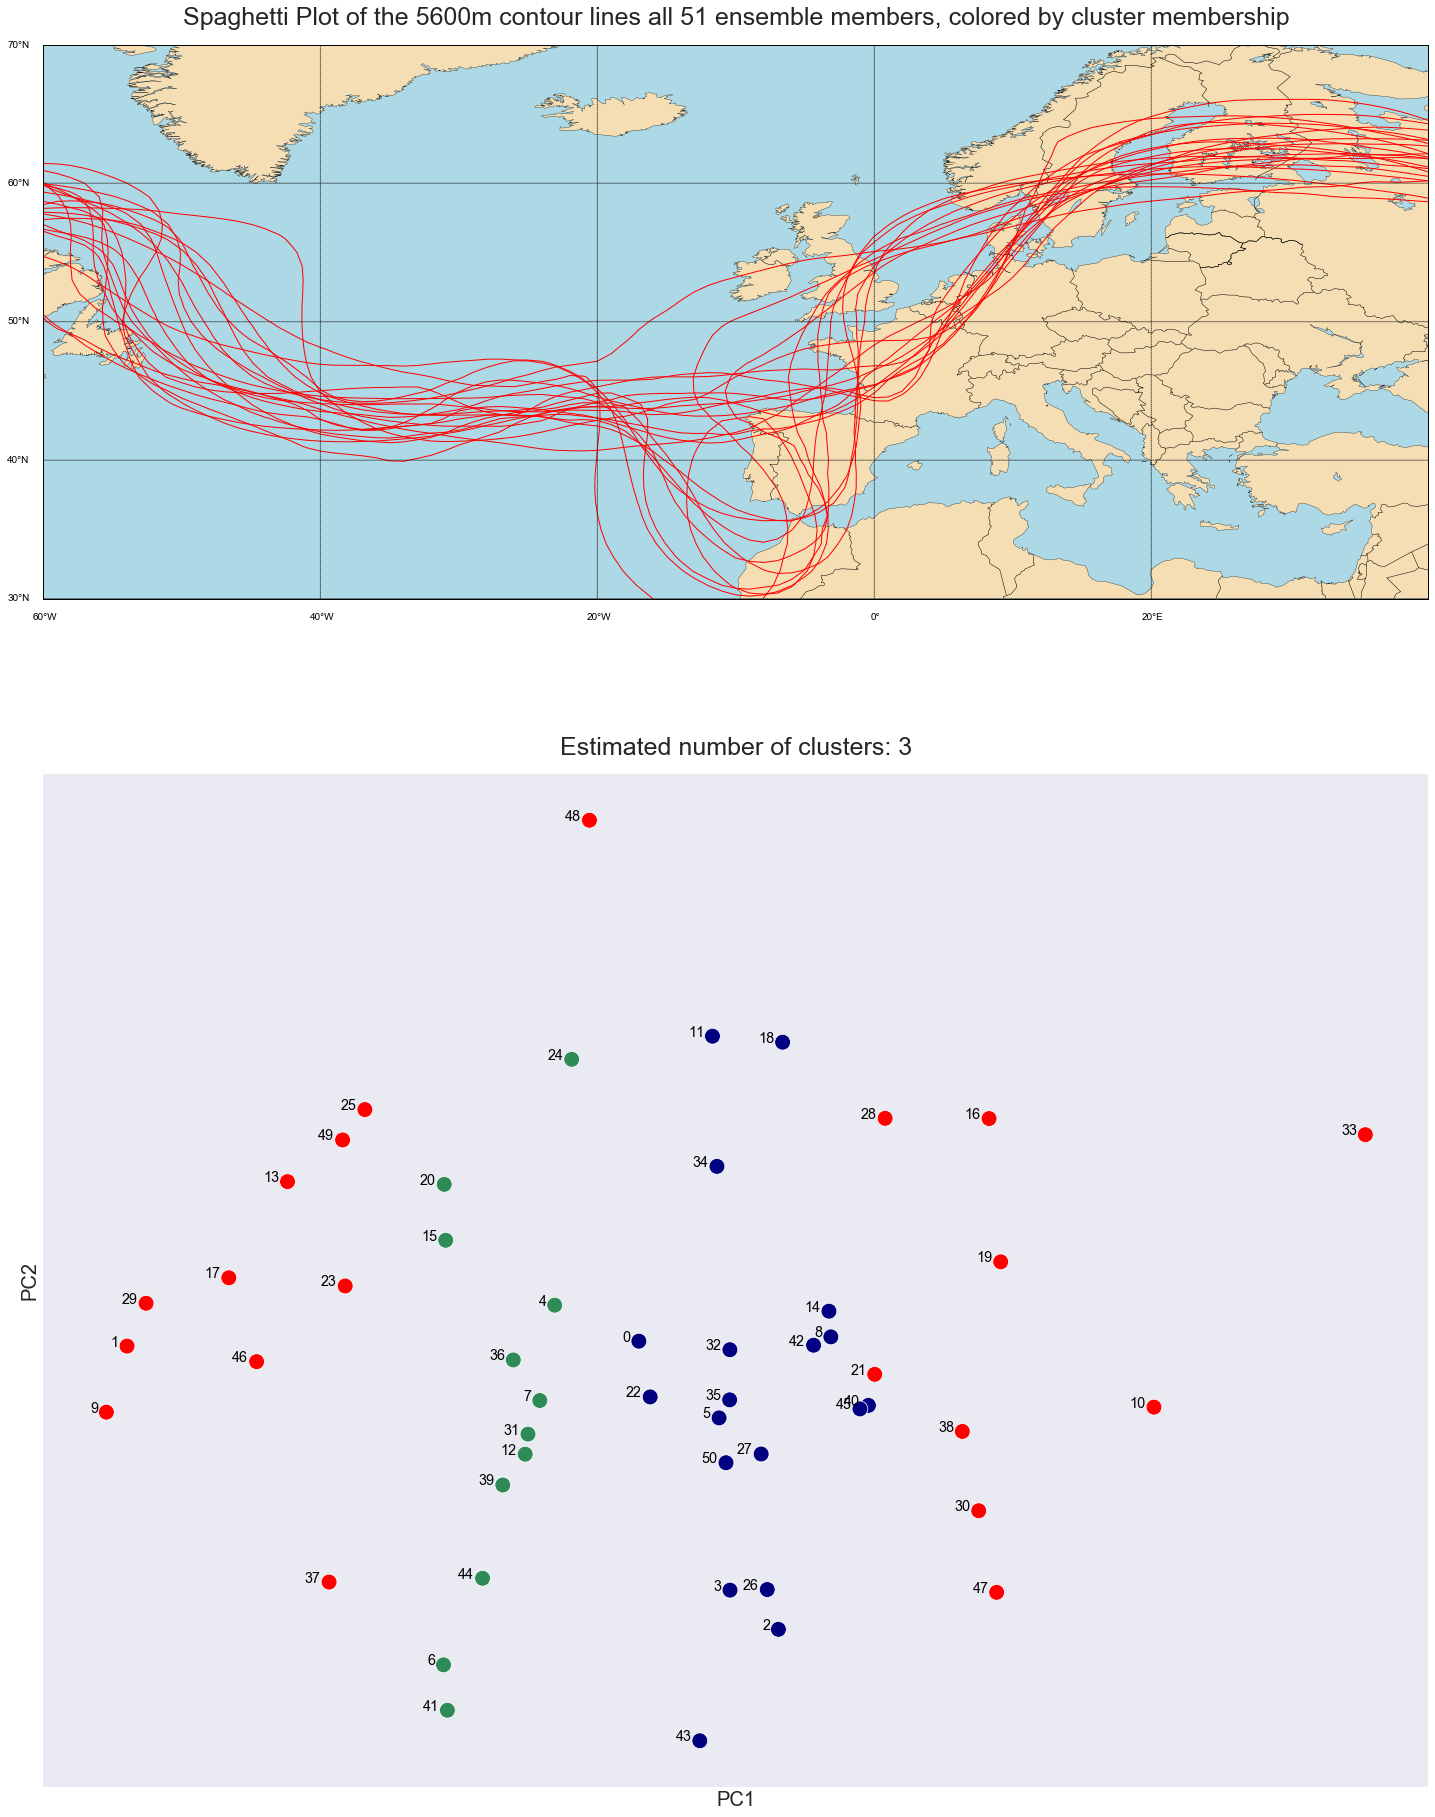

In [123]:
plt.style.use('seaborn-darkgrid')
#pp = PdfPages('KMeans.pdf')
fig = plt.subplots(figsize = (20, 28))
gs = gridspec.GridSpec(2, 1)
# get the cluster result in forms of labels
labels = np.array(labels_)
# Number of clusters in labels, ignoring noise if exist.
n_clusters_ = len(set(labels))
# set color scope
arr_colors = ["red","seagreen","navy","orangered","cyan"]
colors=arr_colors[0:len(set(labels))]
# extract unique label
unique_labels = set(labels)

ax0 = plt.subplot(gs[0])
ax0.set_title("Spaghetti Plot of the 5600m contour lines all 51 ensemble members, colored by cluster membership", fontsize = 25, pad = 20)
map1 = Basemap(projection ='cyl',llcrnrlat = latitude[-1], urcrnrlat = latitude[0], resolution ='l',  llcrnrlon = longitude[0], urcrnrlon = longitude[-1])
map1.drawcoastlines(linewidth = 0.3)
map1.drawmapboundary(fill_color ="lightblue")
map1.fillcontinents(color = "wheat")
map1.drawcountries()
map1.drawparallels(np.arange(30, 75, 10), labels = [True,False,False,False])
map1.drawmeridians(np.arange(-60, 40, 20), labels = [False,False,False,True])

for index, value in enumerate(labels):
    if value == 0:
        map1.contour(lon, lat, Geopotential_Isobaric_500[index, :, :], levels = [5600], colors = colors[value], linewidths = 1)

ax1 = plt.subplot(gs[1])
dfm = pd.DataFrame({'label':labels,
                   'PC1':pca_transformed_data[:, 0],
                   'PC2':pca_transformed_data[:, 1]})
ax1.set_title('Estimated number of clusters: %d' % n_clusters_, fontsize = 25, pad = 20)

sp = sns.scatterplot(x="PC1", y="PC2", hue="label", data=dfm, s=250, palette=colors, legend=False)
for line in range(0,dfm.shape[0]):
     sp.text(dfm.PC1[line]-50, dfm.PC2[line], dfm.index[line], horizontalalignment='right', size='x-large', color='black', weight='light')
       
ax1.set_xticks(())
ax1.set_yticks(())
ax1.set_xlabel("PC1",{'fontsize': '20'})
ax1.set_ylabel("PC2",{'fontsize': '20'})
plt.tight_layout()

#plt.savefig(pp, format='pdf', bbox_inches="tight")
#pp.close()